# Explore here

In [1]:
import pandas as pd
import numpy as np
import re
import os
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load

total_data2024 = pd.read_excel("../data/raw/all_alpha_24.xlsx")
total_data2023 = pd.read_excel("../data/raw/all_alpha_23.xlsx")
total_data2022 = pd.read_excel("../data/raw/all_alpha_22.xlsx")
total_data2021 = pd.read_excel("../data/raw/all_alpha_21.xlsx")
total_data2020 = pd.read_excel("../data/raw/all_alpha_20.xlsx")
total_data2019 = pd.read_excel("../data/raw/all_alpha_19.xlsx")
total_data2018 = pd.read_excel("../data/raw/all_alpha_18.xlsx")
total_data2017 = pd.read_excel("../data/raw/all_alpha_17.xlsx")
total_data2016 = pd.read_excel("../data/raw/all_alpha_16.xlsx")
total_data2015 = pd.read_excel("../data/raw/all_alpha_15.xlsx")
total_data2014 = pd.read_excel("../data/raw/all_alpha_14.xlsx")
total_data2013 = pd.read_excel("../data/raw/all_alpha_13.xlsx")
total_data2012 = pd.read_excel("../data/raw/all_alpha_12.xlsx")
total_data2011 = pd.read_excel("../data/raw/all_alpha_11.xlsx")
total_data2010 = pd.read_excel("../data/raw/all_alpha_10.xls")
total_data2009 = pd.read_excel("../data/raw/all_alpha_09.xls")
total_data2008 = pd.read_excel("../data/raw/all_alpha_08.xls")
total_data2007 = pd.read_excel("../data/raw/all_alpha_07.xls")
total_data2006 = pd.read_excel("../data/raw/all_alpha_06.xls")
total_data2005 = pd.read_excel("../data/raw/all_alpha_05.xls")
total_data2004 = pd.read_excel("../data/raw/all_alpha_04.xls")
total_data2003 = pd.read_excel("../data/raw/all_alpha_03.xls")
total_data2002 = pd.read_excel("../data/raw/all_alpha_02.xls")
total_data2001 = pd.read_excel("../data/raw/all_alpha_01.xls")
total_data2000 = pd.read_excel("../data/raw/all_alpha_00 (1).xls")

In [2]:
total_data2024['Year'] = 2024
total_data2023['Year'] = 2023
total_data2022['Year'] = 2022
total_data2021['Year'] = 2021
total_data2020['Year'] = 2020
total_data2019['Year'] = 2019
total_data2018['Year'] = 2018
total_data2017['Year'] = 2017
total_data2016['Year'] = 2016
total_data2015['Year'] = 2015
total_data2014['Year'] = 2014
total_data2013['Year'] = 2013
total_data2012['Year'] = 2012
total_data2011['Year'] = 2011
total_data2010['Year'] = 2010
total_data2009['Year'] = 2009
total_data2008['Year'] = 2008
total_data2007['Year'] = 2007
total_data2006['Year'] = 2006
total_data2005['Year'] = 2005
total_data2004['Year'] = 2004
total_data2003['Year'] = 2003
total_data2002['Year'] = 2002
total_data2001['Year'] = 2001
total_data2000['Year'] = 2000

In [3]:
# Concatenating all of the data sets

merged_data = pd.concat([total_data2024, total_data2023, total_data2022, total_data2021, total_data2020, 
                         total_data2019, total_data2018, total_data2017, total_data2016, total_data2015, 
                         total_data2014, total_data2013, total_data2012, total_data2011, total_data2010, 
                         total_data2009, total_data2008, total_data2007, total_data2006, total_data2005, 
                         total_data2004, total_data2003, total_data2002, total_data2001, total_data2000], ignore_index=True)

In [4]:
merged_data.drop_duplicates(subset=merged_data.columns.difference(['Cert Region', 'Stnd', 'Stnd Description', 'Sales Area']), inplace=True)

In [5]:
# Cleaning up syntax/grammatical errors to refine values

merged_data['Fuel'] = merged_data['Fuel'].replace('Gasoline/Electricty', 'Gasoline/Electricity')
merged_data['Fuel'] = merged_data['Fuel'].replace('ethanol', 'Ethanol')
merged_data['Fuel'] = merged_data['Fuel'].replace('diesel', 'Diesel')
merged_data['Fuel'] = merged_data['Fuel'].replace('ethanol/gas', 'Ethanol/Gas')
merged_data['Fuel'] = merged_data['Fuel'].replace('Ethanol/Gas', 'Ethanol/Gasoline')
merged_data['Fuel'] = merged_data['Fuel'].replace('CNG/gas', 'CNG/Gasoline')

In [6]:
# Addressing the repeated values for the same # of cylinders for vehicles by merging with their respective counterpart

def convert_cyl(row):
    if row['Cyl'] == '(6 cyl)':
        return 6.0
    elif row['Cyl'] == '(4 cyl)':
        return 4.0
    elif row['Cyl'] == '(12 cyl)':
        return 12.0
    elif row['Cyl'] == '(8 cyl)':
        return 8.0
    elif row['Cyl'] == '(10 cyl)':
        return 10.0
    elif row['Cyl'] == '(16 cyl)':
        return 16.0
    elif row['Cyl'] == '(5 cyl)':
        return 5.0
    elif row['Cyl'] == '(2 cyl)':
        return 2.0
    elif row['Cyl'] == '(3 cyl)':
        return 3.0
    else:
        return row['Cyl']

merged_data['Cyl'] = merged_data.apply(convert_cyl, axis=1)

In [7]:
# Creating a function to manage the Make's that have two words

def split_model(row):
    if 'ASTON MARTIN' in row['Model']:
        return 'ASTON MARTIN', row['Model'].replace('ASTON MARTIN ', '')
    elif 'LAND ROVER' in row['Model']:
        return 'LAND ROVER', row['Model'].replace('LAND ROVER ', '')
    elif 'ALFA ROMEO' in row['Model']:
        return 'ALFA ROMEO', row['Model'].replace('ALFA ROMEO ', '')
    elif 'VEHICLE PRODUCTION GROUP' in row['Model']:
        return 'VEHICLE PRODUCTION GROUP', row['Model'].replace('VEHICLE PRODUCTION GROUP ', '')
    else:
        return row['Model'].split(maxsplit=1)

In [8]:
# Splitting up the 'Model' feature into 2 columns (Make and Model)

merged_data[['Car_Make', 'Car_Model']] = merged_data.apply(split_model, axis=1, result_type='expand')

In [9]:
# Fixing the 'Electricity/Gasoline' row to 'Gasoline/Electricity' along with MPG columns

def reverse_mpg_values(df):
    # Filter rows where Fuel is 'Electricity/Gasoline'
    filter_condition = df['Fuel'] == 'Electricity/Gasoline'
    filtered_df = df[filter_condition].copy()
    # Change 'Electricity/Gasoline' to 'Gasoline/Electricity'
    filtered_df.loc[:, 'Fuel'] = 'Gasoline/Electricity'
    # Check if columns exist before splitting
    if 'City MPG' in filtered_df.columns:
        # Reverse the 'City MPG' values
        filtered_df[['Gasoline_City_MPG', 'Electricity_City_MPG']] = filtered_df['City MPG'].str.split('/', expand=True)
        filtered_df['City MPG'] = filtered_df['Electricity_City_MPG'] + '/' + filtered_df['Gasoline_City_MPG']
    if 'Hwy MPG' in filtered_df.columns:
        # Reverse the 'Hwy MPG' values
        filtered_df[['Gasoline_Hwy_MPG', 'Electricity_Hwy_MPG']] = filtered_df['Hwy MPG'].str.split('/', expand=True)
        filtered_df['Hwy MPG'] = filtered_df['Electricity_Hwy_MPG'] + '/' + filtered_df['Gasoline_Hwy_MPG']
    if 'Cmb MPG' in filtered_df.columns:
        # Reverse the 'Cmb MPG' values
        filtered_df[['Gasoline_Cmb_MPG', 'Electricity_Cmb_MPG']] = filtered_df['Cmb MPG'].str.split('/', expand=True)
        filtered_df['Cmb MPG'] = filtered_df['Electricity_Cmb_MPG'] + '/' + filtered_df['Gasoline_Cmb_MPG']
    # Drop unnecessary columns
    columns_to_drop = ['Gasoline_City_MPG', 'Electricity_City_MPG', 'Gasoline_Hwy_MPG', 'Electricity_Hwy_MPG',
                       'Gasoline_Cmb_MPG', 'Electricity_Cmb_MPG']
    filtered_df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
    # Update the original DataFrame with the modified values
    df.update(filtered_df)
    return df

merged_data = reverse_mpg_values(merged_data)

In [10]:
# Removing unnecessary features with our dataset

columns_to_remove = ['Model', 
                     'Cert Region', 
                     'Comb CO2', 
                     'Stnd',
                     'Trans', 
                     'Stnd Description', 
                     'Underhood ID',  
                     'Sales Area', 
                     'FE Calc Appr', 
                     'Unadj Cmb MPG', 
                     'Comb CO2',
                     'SmartWay']

for column in columns_to_remove:
    try:
        merged_data = merged_data.drop(column, axis=1)
    except:
        print(f"Column {column} was already removed.")

Column Comb CO2 was already removed.


In [11]:
# Creating average with APS/Greenhouse Gas features to address the slashes

def calculate_average(value):
    if pd.isna(value):  # Check if value is NaN
        return np.nan  # Return NaN if value is NaN
    if isinstance(value, str) and '/' in value:
        nums = [float(num) for num in value.split('/') if num.isdigit()]
        if len(nums) == 0:
            return np.nan  # Return NaN if no numeric values are found
        return sum(nums) / len(nums)
    elif isinstance(value, int) or isinstance(value, float):
        return float(value)  # Return value if it's a
merged_data['Air Pollution Score'] = merged_data['Air Pollution Score'].apply(calculate_average)
merged_data['Greenhouse Gas Score'] = merged_data['Greenhouse Gas Score'].apply(calculate_average)

In [12]:
# Drop rows containing 'N/A*'
merged_data = merged_data[~merged_data['City MPG'].astype(str).str.contains('N/A*')]

In [13]:
# Drop rows containing 'nan'
merged_data = merged_data[~merged_data['City MPG'].astype(str).str.contains('nan')]

In [14]:
# Converting 'Displ' values of Electric to Nans to be able to create plotting comparisons
merged_data['Displ'] = pd.to_numeric(merged_data['Displ'], errors='coerce')

In [15]:
#for cylinders, since electric cars don't have cylinders, we replace the nan value with their fuel type of Electric
def handle_nan(row):
    if pd.isna(row['Cyl']):
        return row['Fuel']  # If NaN, copy value from 'Fuel' column
    else:
        return row['Cyl']  # Return the original value if not NaN

In [16]:
# Drop rows containing NaN in City MPG column
merged_data.dropna(subset=['City MPG',], inplace=True)

In [17]:
# Replace 'City MPG' with the actual column name if it's different
unique_values = merged_data["City MPG"].unique()

# Define a regular expression pattern to match any string containing a number
pattern = re.compile(r'\d')

# Iterate over unique values
for value in unique_values:
    if not pd.isnull(value) and not pattern.search(str(value)):
        print(value)

In [18]:
# Convert "Air Pollution Score" column to string type
merged_data["Air Pollution Score"] = merged_data["Air Pollution Score"].astype(str)

# Filter out rows where "Air Pollution Score" column contains the word "Mod"
filtered_data = merged_data[~merged_data["Air Pollution Score"].str.contains("Mod")]

# Calculate the minimum and maximum values
air_pollution_min = filtered_data["Air Pollution Score"].min()
air_pollution_max = filtered_data["Air Pollution Score"].max()

# Print the range
print("Range of values in the column (excluding 'Mod'):", air_pollution_min, "-", air_pollution_max)

Range of values in the column (excluding 'Mod'): 0.0 - nan


In [19]:
# Function to create new column IsHybrid / Not Hybrid

def split_fuel_records(df):
    new_rows = []
    for index, row in df.iterrows():
        fuel = row['Fuel']
        city_mpg = row['City MPG']
        # Initialize IsHybrid column with default value
        row['IsHybrid'] = 'Not Hybrid'
        # Update IsHybrid based on fuel type
        if fuel == 'Gasoline/Electricity':
            row['IsHybrid'] = 'Electric Hybrid'
        elif fuel == 'Ethanol/Gas':
            row['IsHybrid'] = 'Ethanol Hybrid'
        if ('/' in fuel) and ('/' in city_mpg):
            fuels = fuel.split('/')
            city_mpgs = city_mpg.split('/')
            for i, fuel_type in enumerate(fuels):
                new_row = row.copy()
                new_row['Fuel'] = fuel_type.strip()
                new_row['City MPG'] = city_mpgs[i].strip()
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    return pd.DataFrame(new_rows)

merged_data = split_fuel_records(merged_data).reset_index(drop=True)

In [20]:
merged_data['City MPG'] = pd.to_numeric(merged_data['City MPG'], errors='coerce')

In [21]:
# Variable 'Column_Name' is the column you want to convert to float
column_name = 'City MPG'

# Convert the column to float
merged_data[column_name] = merged_data[column_name].astype(float)

In [22]:
merged_data = merged_data[(merged_data['Year'] >= 2000) & (merged_data['Year'] <= 2024)]

In [23]:
average_city_mpg_by_year = merged_data.groupby('Year')['City MPG'].mean().reset_index()

In [24]:
average_city_mpg_by_year.columns = ['Year', 'Average City MPG']

print(average_city_mpg_by_year)

    Year  Average City MPG
0   2000         16.447970
1   2001         16.600840
2   2002         16.445561
3   2003         16.413223
4   2004         17.161004
5   2005         17.215054
6   2006         17.085414
7   2007         16.590000
8   2008         17.189342
9   2009         17.527833
10  2010         18.384574
11  2011         18.705348
12  2012         19.212045
13  2013         20.347665
14  2014         21.129939
15  2015         21.708534
16  2016         22.699733
17  2017         23.373126
18  2018         23.624328
19  2019         24.726396
20  2020         25.292160
21  2021         26.099564
22  2022         27.716032
23  2023         32.172367
24  2024         35.306011


In [25]:
# Filtering amongst columns 'Fuel', 'Year', and 'City MPG' to find avg MPG's by year and by fuel type (2000-2024)

if 'Year' in merged_data.columns and 'City MPG' in merged_data.columns and 'Fuel' in merged_data.columns:
    # Filter the dataset for the years 2000 to 2024
    filtered_data = merged_data[(merged_data['Year'] >= 2000) & (merged_data['Year'] <= 2024)]
    
    # Further filter the dataset to include only the specified 'Fuel' types
    fuel_types = ['Gasoline', 'Electricity', 'Gasoline/Electricity']
    filtered_data = filtered_data[filtered_data['Fuel'].isin(fuel_types)]
    
    # Group by 'Year' and 'Fuel', and calculate the average 'City MPG'
    average_city_mpg_by_year_and_fuel = filtered_data.groupby(['Year', 'Fuel'])['City MPG'].mean().reset_index()
    
    # Rename columns for clarity
    average_city_mpg_by_year_and_fuel.columns = ['Year', 'Fuel', 'Average City MPG']
    
    # Print or inspect the results
    print(average_city_mpg_by_year_and_fuel)
else:
    print("The dataset does not contain the necessary 'Year', 'City MPG', and 'Fuel' columns.")

    Year                  Fuel  Average City MPG
0   2000              Gasoline         16.444109
1   2001              Gasoline         16.562607
2   2002              Gasoline         16.346644
3   2003              Gasoline         16.343010
4   2004              Gasoline         17.200457
5   2005              Gasoline         17.268202
6   2006              Gasoline         17.117766
7   2007              Gasoline         16.854455
8   2008              Gasoline         17.447275
9   2009              Gasoline         17.948294
10  2010              Gasoline         18.727995
11  2011           Electricity         99.200000
12  2011              Gasoline         19.019355
13  2012           Electricity         82.416667
14  2012              Gasoline         19.504778
15  2013           Electricity        104.952381
16  2013              Gasoline         20.180599
17  2013  Gasoline/Electricity         51.000000
18  2014           Electricity         96.705882
19  2014            

In [26]:
# Ensure 'Year', 'City MPG', 'Fuel', and 'Car_Make' columns exist
if all(col in merged_data.columns for col in ['Year', 'City MPG', 'Fuel', 'Car_Make']):
    # Filter the dataset for the years 2000 to 2024
    filtered_data = merged_data[(merged_data['Year'] >= 2000) & (merged_data['Year'] <= 2024)]
    
    # Further filter the dataset to include only the specified 'Fuel' types
    fuel_types = ['Gasoline', 'Electricity', 'Gasoline/Electricity']
    filtered_data = filtered_data[filtered_data['Fuel'].isin(fuel_types)]
    
    # Group by 'Year', 'Fuel', and 'Car_Make', and calculate the average 'City MPG'
    average_city_mpg_by_year_fuel_and_make = filtered_data.groupby(['Year', 'Fuel', 'Car_Make'])['City MPG'].mean().reset_index()
    
    # Rename columns for clarity
    average_city_mpg_by_year_fuel_and_make.columns = ['Year', 'Fuel', 'Car Make', 'Average City MPG']
    
    pd.set_option('display.max_rows', 1500)

    # Print or inspect the results
    print(average_city_mpg_by_year_fuel_and_make)
else:
    print("The dataset does not contain the necessary 'Year', 'City MPG', 'Fuel', and 'Car_Make' columns.")

      Year                  Fuel                  Car Make  Average City MPG
0     2000              Gasoline                     ACURA         15.000000
1     2000              Gasoline              ASTON MARTIN          8.000000
2     2000              Gasoline                      AUDI         13.517241
3     2000              Gasoline                   BENTLEY          8.166667
4     2000              Gasoline                       BMW         13.054054
5     2000              Gasoline                     BUICK         13.833333
6     2000              Gasoline                  CADILLAC         12.111111
7     2000              Gasoline                 CHEVROLET         16.042683
8     2000              Gasoline                  CHRYSLER         16.272727
9     2000              Gasoline                    DAEWOO         20.300000
10    2000              Gasoline                     DODGE         13.630000
11    2000              Gasoline                   FERRARI          9.200000

In [27]:
merged_data

Displ  Cyl Drive      Fuel      Veh Class Air Pollution Score  \
0        1.5  4.0   2WD  Gasoline      large car                 7.0   
1        2.0  4.0   2WD  Gasoline      large car                 6.0   
2        1.5  4.0   2WD  Gasoline      large car                 6.0   
3        1.5  4.0   2WD  Gasoline      large car                 7.0   
4        3.5  6.0   2WD  Gasoline      small SUV                 5.0   
...      ...  ...   ...       ...            ...                 ...   
41247    2.4  5.0   4WD  Gasoline  station wagon                 nan   
41248    2.4  5.0   4WD  Gasoline  station wagon                 nan   
41249    2.4  5.0   2WD  Gasoline  station wagon                 nan   
41250    2.4  5.0   2WD  Gasoline  station wagon                 nan   
41251    2.4  5.0   2WD  Gasoline  station wagon                 nan   

       City MPG Hwy MPG Cmb MPG  Greenhouse Gas Score  Year Car_Make  \
0          30.0      37      33                   6.0  2024    ACURA   
1          21.0      28      24                   5.0  2024    ACURA   
2          26.0      36      30                   6.0  2024    ACURA   
3          29.0      36      32                   6.0  2024    ACURA   
4          19.0      26      22                   5.0  2024    ACURA   
...         ...     ...     ...                   ...   ...      ...   
41247      16.0      22      18                   NaN  2000    VOLVO   
41248      16.0      23      19                   NaN  2000    VOLVO   
41249      17.0      24      20                   NaN  2000    VOLVO   
41250      18.0      26      21                   NaN  2000    VOLVO   
41251      19.0      26      22                   NaN  2000    VOLVO   

            Car_Model    IsHybrid  
0             Integra  Not Hybrid  
1             Integra  Not Hybrid  
2      Integra A-Spec  Not Hybrid  
3      Integra A-Spec  Not Hybrid  
4                 MDX  Not Hybrid  
...               ...         ...  
41247             V70  Not Hybrid  
41248             V70  Not Hybrid  
41249             V70  Not Hybrid  
41250             V70  Not Hybrid  
41251             V70  Not Hybrid  

[41252 rows x 14 columns]

In [28]:
nan_count_per_column = {col: merged_data[col].astype(str).str.count('nan').sum() for col in merged_data.columns}

print("Count of occurrences of 'nan' in each column:")
for col, count in nan_count_per_column.items():
    print(f"{col}: {count}")

Count of occurrences of 'nan' in each column:
Displ: 803
Cyl: 807
Drive: 0
Fuel: 0
Veh Class: 0
Air Pollution Score: 26277
City MPG: 0
Hwy MPG: 0
Cmb MPG: 0
Greenhouse Gas Score: 28489
Year: 0
Car_Make: 0
Car_Model: 11
IsHybrid: 0


In [29]:
merged_data["Cyl"].unique()

array([ 4.,  6.,  8., 12., nan,  5., 16.,  3., 10.,  2.])

In [30]:
na_count_per_column = {col: merged_data[col].astype(str).str.count('nan').sum() for col in merged_data.columns}

print("Count of occurrences of 'N/A*' in each column:")
for col, count in na_count_per_column.items():
    print(f"{col}: {count}")

Count of occurrences of 'N/A*' in each column:
Displ: 803
Cyl: 807
Drive: 0
Fuel: 0
Veh Class: 0
Air Pollution Score: 26277
City MPG: 0
Hwy MPG: 0
Cmb MPG: 0
Greenhouse Gas Score: 28489
Year: 0
Car_Make: 0
Car_Model: 11
IsHybrid: 0


In [31]:
merged_data['Displ'].unique() # both nan and -1 values need to be addressed

array([ 1.5,  2. ,  3.5,  3. ,  2.9,  1.3,  4. ,  5.2,  nan,  2.5,  6. ,
        4.4,  8. ,  3.6,  1.2,  2.7,  6.2,  5.5,  5.3,  5.7,  6.4,  6.5,
        3.9,  2.3,  3.3,  5. ,  1.6,  3.8,  5.6,  3.4,  2.4,  3.7,  6.7,
        1.8,  4.6,  6.6,  1.4,  2.8,  3.2,  0.6,  4.3,  1. ,  6.8,  4.2,
        6.3,  4.7,  2.2,  4.8,  8.4,  0.9,  5.9,  2.1,  7. ,  4.5,  5.4,
        5.8, -1. ,  6.1,  3.1,  8.3,  1.9,  1.7,  2.6,  4.9,  4.1])

In [32]:
merged_data["Air Pollution Score"].unique() # nan values

array(['7.0', '6.0', '5.0', '3.0', '10.0', '8.0', '1.0', '9.0', '2.0',
       'nan', '4.0', '0.0'], dtype=object)

In [33]:
merged_data["Greenhouse Gas Score"].unique() # nan values

array([ 6. ,  5. ,  4. ,  9. ,  3. ,  2. , 10. ,  8. ,  7. ,  1. ,  nan,
        1.5,  2.5,  3.5,  5.5,  4.5,  6.5,  0. ,  7.5,  0.5])

Groupby to assess counts/nans/etc.

In [34]:
merged_data.groupby('Fuel').apply(lambda x: x.isnull().sum())

/tmp/ipykernel_1271/857128186.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data.groupby('Fuel').apply(lambda x: x.isnull().sum())


Displ  Cyl  Drive  Fuel  Veh Class  Air Pollution Score  \
Fuel                                                                            
CNG                       0    0      0     0          0                    0   
CNG/Gasoline              0    0      0     0          0                    0   
Diesel                    0    0      0     0          0                    0   
Electricity             764  768      0     0          0                    0   
Ethanol                   0    0      0     0          0                    0   
Gasoline                  0    0      0     0          0                    0   
Gasoline/Electricity      0    0      0     0          0                    0   
Hydrogen                 39   39      0     0          0                    0   

                      City MPG  Hwy MPG  Cmb MPG  Greenhouse Gas Score  Year  \
Fuel                                                                           
CNG                          0        0        0                    68     0   
CNG/Gasoline                 0        0        0                     1     0   
Diesel                       0        0        0                   271     0   
Electricity                  0        0        0                   175     0   
Ethanol                      0        0        0                   765     0   
Gasoline                     0        0        0                 27201     0   
Gasoline/Electricity         0        0        0                     1     0   
Hydrogen                     0        0        0                     7     0   

                      Car_Make  Car_Model  IsHybrid  
Fuel                                                 
CNG                          0          0         0  
CNG/Gasoline                 0          0         0  
Diesel                       0          0         0  
Electricity                  0          0         0  
Ethanol                      0          0         0  
Gasoline                     0          0         0  
Gasoline/Electricity         0          0         0  
Hydrogen                     0          0         0

In [35]:
electricity_data = merged_data[merged_data['Fuel'] == 'Electricity']
electricity_data

Displ  Cyl Drive         Fuel        Veh Class Air Pollution Score  \
19       1.3  4.0   4WD  Electricity        small SUV                 6.0   
40       NaN  NaN   2WD  Electricity     standard SUV                10.0   
41       NaN  NaN   4WD  Electricity     standard SUV                10.0   
42       NaN  NaN   4WD  Electricity     standard SUV                10.0   
44       2.0  4.0   4WD  Electricity        small SUV                 7.0   
50       NaN  NaN   4WD  Electricity     standard SUV                10.0   
51       NaN  NaN   4WD  Electricity     standard SUV                10.0   
52       NaN  NaN   4WD  Electricity     standard SUV                10.0   
60       NaN  NaN   4WD  Electricity      midsize car                10.0   
73       NaN  NaN   4WD  Electricity     standard SUV                10.0   
74       NaN  NaN   4WD  Electricity     standard SUV                10.0   
75       NaN  NaN   4WD  Electricity     standard SUV                10.0   
76       NaN  NaN   4WD  Electricity     standard SUV                10.0   
77       NaN  NaN   4WD  Electricity      midsize car                10.0   
81       3.0  6.0   4WD  Electricity     standard SUV                 3.0   
89       2.9  6.0   4WD  Electricity      midsize car                 5.0   
95       2.0  4.0   2WD  Electricity        small car                 7.0   
97       2.0  4.0   4WD  Electricity        small car                 7.0   
112      3.0  6.0   4WD  Electricity        large car                 7.0   
166      3.0  6.0   4WD  Electricity     standard SUV                 7.0   
173      4.4  8.0   4WD  Electricity     standard SUV                 7.0   
175      4.4  8.0   4WD  Electricity     standard SUV                 7.0   
178      NaN  NaN   4WD  Electricity        small car                10.0   
179      NaN  NaN   4WD  Electricity        small car                10.0   
180      NaN  NaN   2WD  Electricity        small car                10.0   
181      NaN  NaN   2WD  Electricity        small car                10.0   
182      NaN  NaN   2WD  Electricity        small car                10.0   
183      NaN  NaN   2WD  Electricity        small car                10.0   
184      NaN  NaN   4WD  Electricity        small car                10.0   
185      NaN  NaN   4WD  Electricity        small car                10.0   
186      NaN  NaN   4WD  Electricity        small car                10.0   
187      NaN  NaN   4WD  Electricity        small car                10.0   
188      NaN  NaN   4WD  Electricity        small car                10.0   
189      NaN  NaN   2WD  Electricity        small car                10.0   
190      NaN  NaN   2WD  Electricity        small car                10.0   
191      NaN  NaN   2WD  Electricity        small car                10.0   
192      NaN  NaN   4WD  Electricity        large car                10.0   
193      NaN  NaN   4WD  Electricity        large car                10.0   
194      NaN  NaN   2WD  Electricity        large car                10.0   
195      NaN  NaN   2WD  Electricity        large car                10.0   
196      NaN  NaN   2WD  Electricity        large car                10.0   
197      NaN  NaN   4WD  Electricity        large car                10.0   
198      NaN  NaN   4WD  Electricity        large car                10.0   
199      NaN  NaN   4WD  Electricity        large car                10.0   
200      NaN  NaN   4WD  Electricity     standard SUV                10.0   
201      NaN  NaN   4WD  Electricity     standard SUV                10.0   
202      NaN  NaN   4WD  Electricity     standard SUV                10.0   
203      NaN  NaN   4WD  Electricity     standard SUV                10.0   
204      NaN  NaN   4WD  Electricity     standard SUV                10.0   
205      NaN  NaN   4WD  Electricity     standard SUV                10.0   
206      NaN  NaN   4WD  Electricity     standard SUV                10.0   
207

In [36]:
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')

In [37]:
# List of car makes we wish to isolate (Electricity)

car_makes = ['FORD', 'TESLA', 'HYUNDAI']

# Step 1: Filter for specific car makes
filtered_data = merged_data[merged_data['Car_Make'].isin(car_makes)]

# Step 2: Filter to include only rows where 'Fuel' is 'Electricity'
electric_vehicles = filtered_data[filtered_data['Fuel'] == 'Electricity']

# Step 3: Sort the data by 'Year'
sorted_electric_vehicles = electric_vehicles.sort_values(by='Year')

# Display the sorted, filtered rows
sorted_electric_vehicles

Displ  Cyl Drive         Fuel      Veh Class Air Pollution Score  \
22271    NaN  NaN   2WD  Electricity      large car                 nan   
18995    2.0  4.0   2WD  Electricity    midsize car                 nan   
18997    2.0  4.0   2WD  Electricity    midsize car                 nan   
19094    NaN  NaN   2WD  Electricity      small car                 nan   
20232    NaN  NaN   2WD  Electricity      large car                 nan   
19123    2.0  4.0   2WD  Electricity    midsize car                 nan   
20230    NaN  NaN   2WD  Electricity      large car                 nan   
20231    NaN  NaN   2WD  Electricity      large car                 nan   
19121    2.0  4.0   2WD  Electricity    midsize car                 nan   
18077    NaN  NaN   2WD  Electricity      large car                 nan   
18076    NaN  NaN   2WD  Electricity      large car                 nan   
18075    NaN  NaN   4WD  Electricity      large car                 nan   
16854    2.0  4.0   2WD  Electricity    midsize car                 nan   
16852    2.0  4.0   2WD  Electricity    midsize car                 nan   
16822    NaN  NaN   2WD  Electricity      small car                 nan   
16718    2.0  4.0   2WD  Electricity    midsize car                 nan   
16716    2.0  4.0   2WD  Electricity    midsize car                 nan   
14478    2.0  4.0   2WD  Electricity    midsize car                 nan   
14480    2.0  4.0   2WD  Electricity    midsize car                 nan   
14563    NaN  NaN   2WD  Electricity      small car                 nan   
14590    2.0  4.0   2WD  Electricity    midsize car                 nan   
15812    NaN  NaN   2WD  Electricity      large car                 nan   
15813    NaN  NaN   2WD  Electricity      large car                 nan   
15814    NaN  NaN   4WD  Electricity      large car                 nan   
15815    NaN  NaN   4WD  Electricity      large car                 nan   
15816    NaN  NaN   4WD  Electricity      large car                 nan   
14592    2.0  4.0   2WD  Electricity    midsize car                 nan   
13528    NaN  NaN   2WD  Electricity      large car                10.0   
12197    2.0  4.0   2WD  Electricity    midsize car                 7.0   
12199    2.0  4.0   2WD  Electricity    midsize car                 9.0   
12297    NaN  NaN   2WD  Electricity      small car                10.0   
12327    2.0  4.0   2WD  Electricity    midsize car                 7.0   
12329    2.0  4.0   2WD  Electricity    midsize car                 9.0   
12586    2.0  4.0   2WD  Electricity    midsize car                 9.0   
13526    NaN  NaN   2WD  Electricity      large car                10.0   
13527    NaN  NaN   2WD  Electricity      large car                10.0   
13529    NaN  NaN   4WD  Electricity      large car                10.0   
13536    NaN  NaN   4WD  Electricity      large car                10.0   
13531    NaN  NaN   4WD  Electricity      large car                10.0   
13532    NaN  NaN   4WD  Electricity      large car                10.0   
13533    NaN  NaN   4WD  Electricity      large car                10.0   
13534    NaN  NaN   4WD  Electricity      large car                10.0   
13535    NaN  NaN   4WD  Electricity      large car                10.0   
13537    NaN  NaN   4WD  Electricity   standard SUV                10.0   
13538    NaN  NaN   4WD  Electricity   standard SUV                10.0   
13539    NaN  NaN   4WD  Electricity   standard SUV                10.0   
13540    NaN  NaN   4WD  Electricity   standard SUV                10.0   
13530    NaN  NaN   4WD  Electricity      large car                10.0   
13541    NaN  NaN   4WD  Electricity   standard SUV                10.0   
11363    NaN  NaN   4WD  Electricity      large car                10.0   
11362    NaN  NaN   2WD  Electricity    midsize car                10.0   
10649    2.0  4.0   2WD  Electricity    midsize car                 8.0   
10624    NaN  NaN   2WD  Electri

In [38]:
sorted_electric_vehicles['Year'] = pd.to_datetime(sorted_electric_vehicles['Year'], format='%Y', errors='coerce')

In [39]:
if all(col in sorted_electric_vehicles.columns for col in ['Year', 'City MPG', 'Fuel', 'Car_Make']):
    # Filter the dataset for the years 2000 to 2024
    filtered_elec_data = sorted_electric_vehicles[(sorted_electric_vehicles['Year'].dt.year >= 2000) & (sorted_electric_vehicles['Year'].dt.year <= 2024)]
    
    # Group by 'Year', 'Fuel', and 'Car_Make', and calculate the average 'City MPG'
    average_city_mpg_by_year_fuel_and_make_elec = filtered_elec_data.groupby([filtered_elec_data['Year'].dt.year, 'Fuel', 'Car_Make'])['City MPG'].mean().reset_index()
    
    # Rename columns for clarity
    average_city_mpg_by_year_fuel_and_make_elec.columns = ['Year', 'Fuel', 'Car Make', 'Average City MPG']
    
    pd.set_option('display.max_rows', 1500)

    # Print or inspect the results
    print(average_city_mpg_by_year_fuel_and_make_elec)
else:
    print("The dataset does not contain the necessary 'Year', 'City MPG', 'Fuel', and 'Car_Make' columns.")

    Year         Fuel Car Make  Average City MPG
0   2012  Electricity    TESLA         88.000000
1   2013  Electricity     FORD         98.000000
2   2013  Electricity    TESLA         91.666667
3   2014  Electricity     FORD         98.000000
4   2014  Electricity    TESLA         89.333333
5   2015  Electricity     FORD         98.000000
6   2015  Electricity    TESLA         93.400000
7   2016  Electricity     FORD         98.000000
8   2016  Electricity  HYUNDAI         99.000000
9   2016  Electricity    TESLA         93.562500
10  2017  Electricity     FORD        106.800000
11  2017  Electricity  HYUNDAI        116.000000
12  2017  Electricity    TESLA         96.266667
13  2018  Electricity     FORD        110.000000
14  2018  Electricity  HYUNDAI        124.000000
15  2018  Electricity    TESLA        105.090909
16  2019  Electricity     FORD        109.000000
17  2019  Electricity  HYUNDAI        126.000000
18  2019  Electricity    TESLA        107.842105
19  2020  Electricit

In [40]:
# Now the gasoline version

# List of car makes we wish to isolate
car_makes = ['FORD', 'CHEVROLET', 'TOYOTA']

# Step 1: Filter for specific car makes
filtered_data = merged_data[merged_data['Car_Make'].isin(car_makes)]

# Step 2: Filter to include only rows where 'Fuel' is 'Gasoline'
gasoline_vehicles = filtered_data[filtered_data['Fuel'] == 'Gasoline']

# Step 3: Sort the data by 'Year'
sorted_gasoline_vehicles = gasoline_vehicles.sort_values(by='Year')

# Display the sorted, filtered rows
sorted_gasoline_vehicles

Displ  Cyl Drive      Fuel    Veh Class Air Pollution Score  City MPG  \
41181    4.7  8.0   4WD  Gasoline       pickup                 nan      13.0   
40120    4.8  8.0   2WD  Gasoline          SUV                 nan      13.0   
40121    4.8  8.0   2WD  Gasoline          SUV                 nan      13.0   
40122    4.8  8.0   4WD  Gasoline          SUV                 nan      13.0   
40123    4.8  8.0   2WD  Gasoline          SUV                 nan      13.0   
...      ...  ...   ...       ...          ...                 ...       ...   
1149     2.5  4.0   2WD  Gasoline  midsize car                 7.0      27.0   
1148     3.5  6.0   2WD  Gasoline  midsize car                 5.0      22.0   
1147     2.5  4.0   4WD  Gasoline  midsize car                 6.0      25.0   
1145     2.5  4.0   2WD  Gasoline  midsize car                 7.0      44.0   
249      2.0  4.0   2WD  Gasoline    small SUV                 7.0      22.0   

      Hwy MPG Cmb MPG  Greenhouse Gas Score       Year   Car_Make  \
41181      16      14                   NaN 2000-01-01     TOYOTA   
40120      17      14                   NaN 2000-01-01  CHEVROLET   
40121      18      15                   NaN 2000-01-01  CHEVROLET   
40122      16      14                   NaN 2000-01-01  CHEVROLET   
40123      17      14                   NaN 2000-01-01  CHEVROLET   
...       ...     ...                   ...        ...        ...   
1149       38      31                   6.0 2024-01-01     TOYOTA   
1148       31      25                   5.0 2024-01-01     TOYOTA   
1147       34      29                   6.0 2024-01-01     TOYOTA   
1145       47      46                   8.0 2024-01-01     TOYOTA   
249        29      25                   5.0 2024-01-01  CHEVROLET   

                     Car_Model    IsHybrid  
41181                   Tundra  Not Hybrid  
40120               Tahoe 1500  Not Hybrid  
40121               Tahoe 1500  Not Hybrid  
40122               Tahoe 1500  Not Hybrid  
40123               Tahoe 1500  Not Hybrid  
...                        ...         ...  
1149             Camry XLE/XSE  Not Hybrid  
1148                 Camry TRD  Not Hybrid  
1147               Camry LE/SE  Not Hybrid  
1145   Camry Hybrid SE/XLE/XSE  Not Hybrid  
249                     Blazer  Not Hybrid  

[7583 rows x 14 columns]

In [41]:
sorted_gasoline_vehicles['Year'] = pd.to_datetime(sorted_gasoline_vehicles['Year'], format='%Y', errors='coerce')

In [42]:
if all(col in sorted_gasoline_vehicles.columns for col in ['Year', 'City MPG', 'Fuel', 'Car_Make']):
    # Filter the dataset for the years 2000 to 2024
    filtered_data = sorted_gasoline_vehicles[(sorted_gasoline_vehicles['Year'].dt.year >= 2000) & (sorted_gasoline_vehicles['Year'].dt.year <= 2024)]
    
    # Further filter the dataset to include only the specified 'Fuel' types
    fuel_types = ['Gasoline', 'Electricity', 'Gasoline/Electricity']
    filtered_data = filtered_data[filtered_data['Fuel'].isin(fuel_types)]
    
    # Group by 'Year', 'Fuel', and 'Car_Make', and calculate the average 'City MPG'
    average_city_mpg_by_year_fuel_and_make = filtered_data.groupby([filtered_data['Year'].dt.year, 'Fuel', 'Car_Make'])['City MPG'].mean().reset_index()
    
    # Rename columns for clarity
    average_city_mpg_by_year_fuel_and_make.columns = ['Year', 'Fuel', 'Car Make', 'Average City MPG']
    
    pd.set_option('display.max_rows', 1500)

    # Print or inspect the results
    print(average_city_mpg_by_year_fuel_and_make)
else:
    print("The dataset does not contain the necessary 'Year', 'City MPG', 'Fuel', and 'Car_Make' columns.")

    Year      Fuel   Car Make  Average City MPG
0   2000  Gasoline  CHEVROLET         16.042683
1   2000  Gasoline       FORD         15.540984
2   2000  Gasoline     TOYOTA         17.666667
3   2001  Gasoline  CHEVROLET         15.113636
4   2001  Gasoline       FORD         15.923810
5   2001  Gasoline     TOYOTA         18.769231
6   2002  Gasoline  CHEVROLET         14.877551
7   2002  Gasoline       FORD         15.848485
8   2002  Gasoline     TOYOTA         18.724138
9   2003  Gasoline  CHEVROLET         14.167702
10  2003  Gasoline       FORD         15.427273
11  2003  Gasoline     TOYOTA         19.190476
12  2004  Gasoline  CHEVROLET         15.240741
13  2004  Gasoline       FORD         16.154762
14  2004  Gasoline     TOYOTA         19.567010
15  2005  Gasoline  CHEVROLET         15.481132
16  2005  Gasoline       FORD         16.880952
17  2005  Gasoline     TOYOTA         19.648148
18  2006  Gasoline  CHEVROLET         15.792793
19  2006  Gasoline       FORD         17

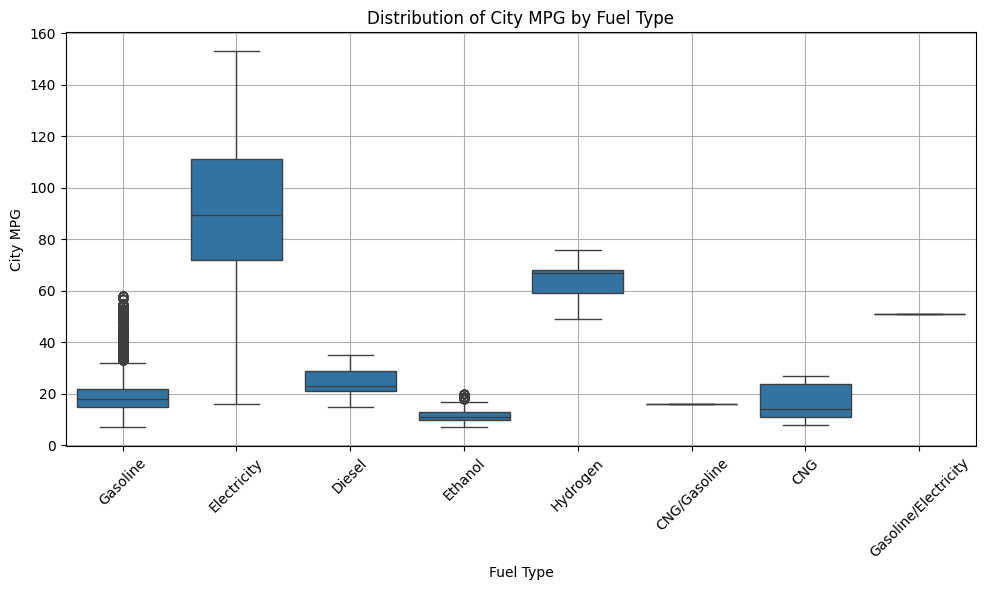

In [43]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Fuel', y='City MPG')
plt.title('Distribution of City MPG by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('City MPG')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

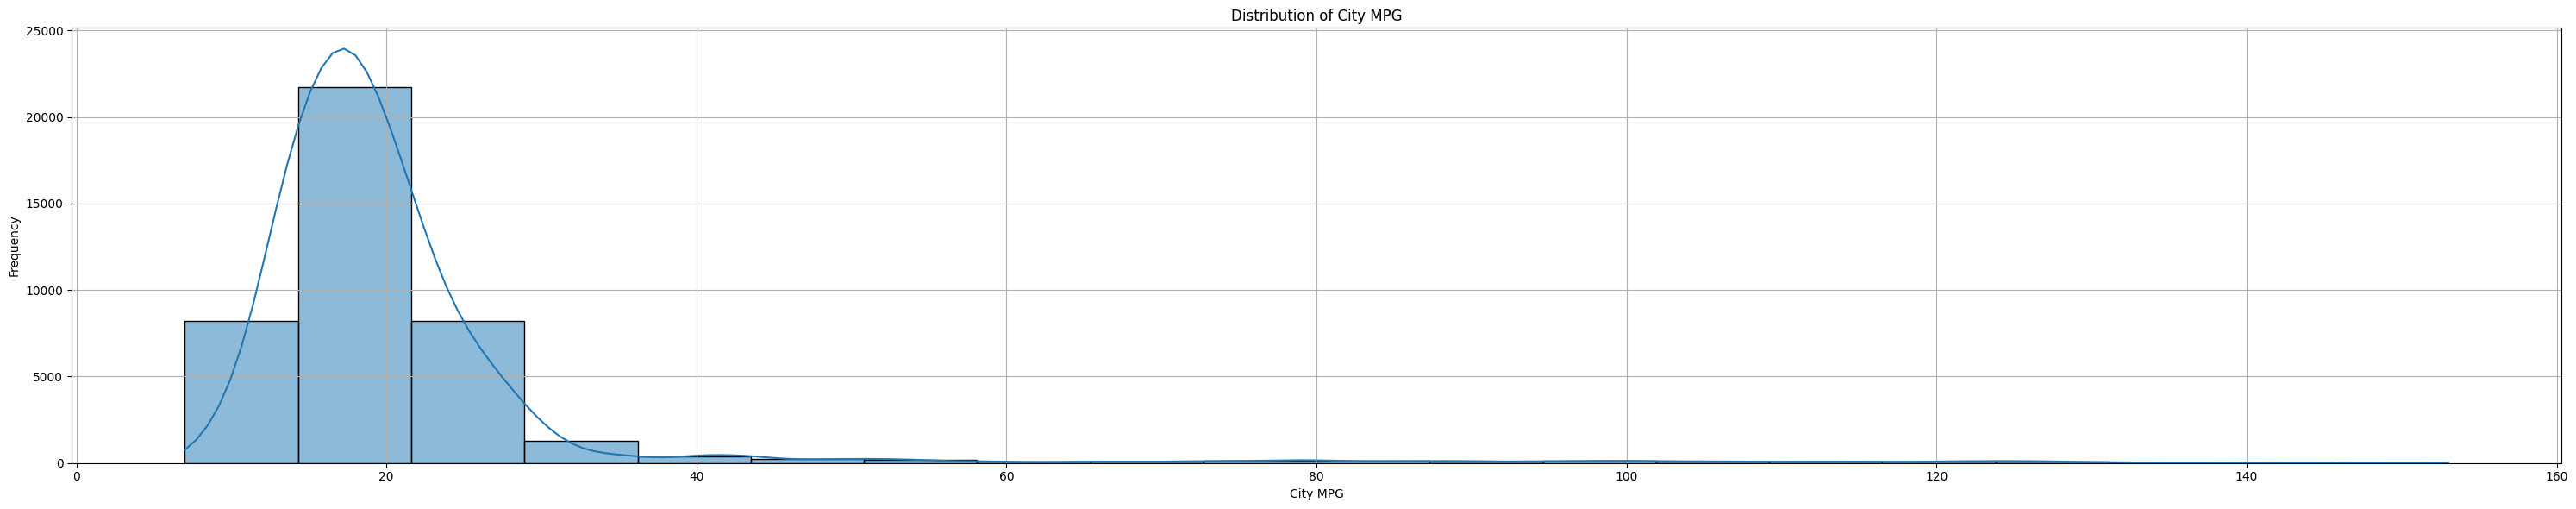

In [44]:
# Histogram
plt.figure(figsize=(30, 6))
sns.histplot(data=merged_data, x='City MPG', bins=20, kde=True)
plt.title('Distribution of City MPG')
plt.xlabel('City MPG')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

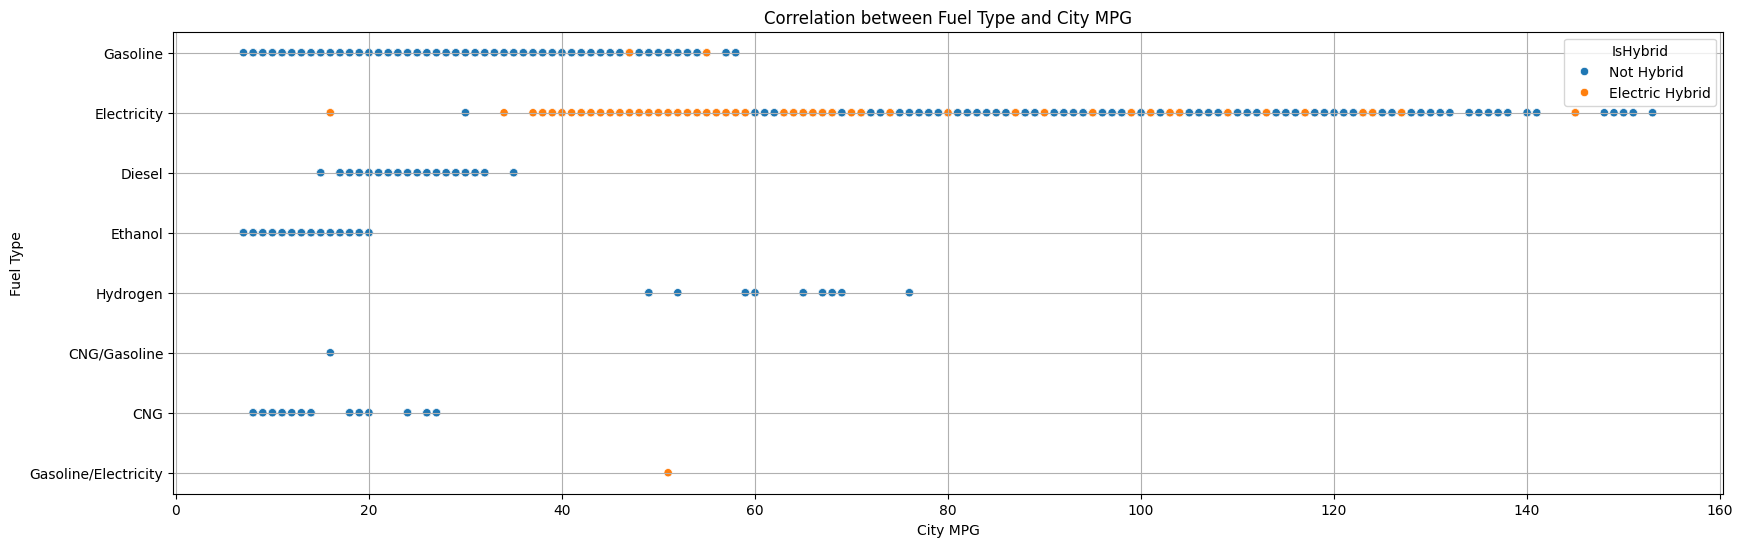

In [45]:
# Scatterplot depicting Hybrids
plt.figure(figsize=(20, 6))
sns.scatterplot(data=merged_data, x='City MPG', y='Fuel', hue='IsHybrid')
plt.title('Correlation between Fuel Type and City MPG')
plt.xlabel('City MPG')
plt.ylabel('Fuel Type')
plt.grid(True)

# Show the plot
plt.show()

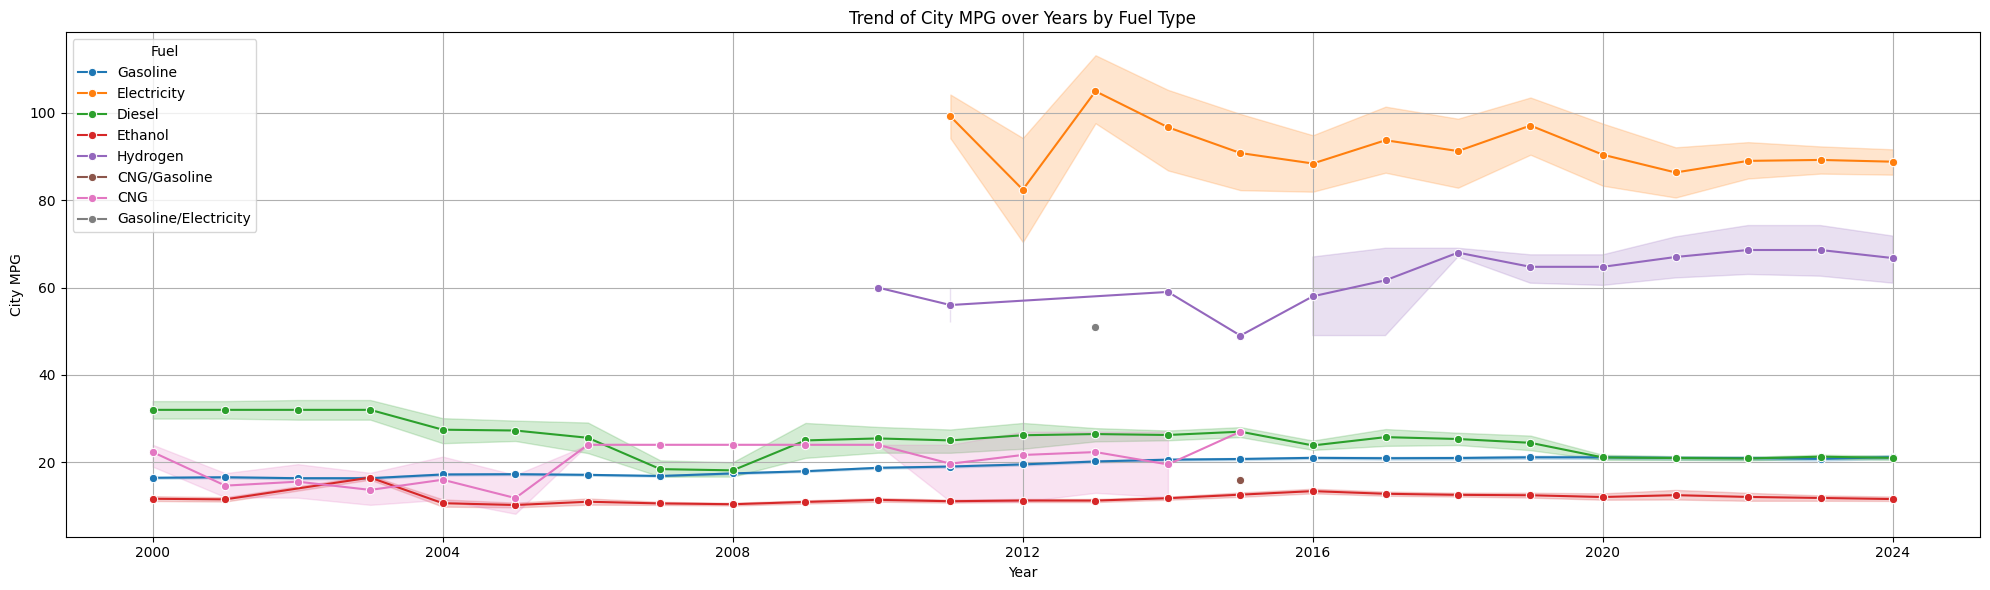

In [46]:
# Line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=merged_data, x='Year', y='City MPG', hue='Fuel', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Fuel')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

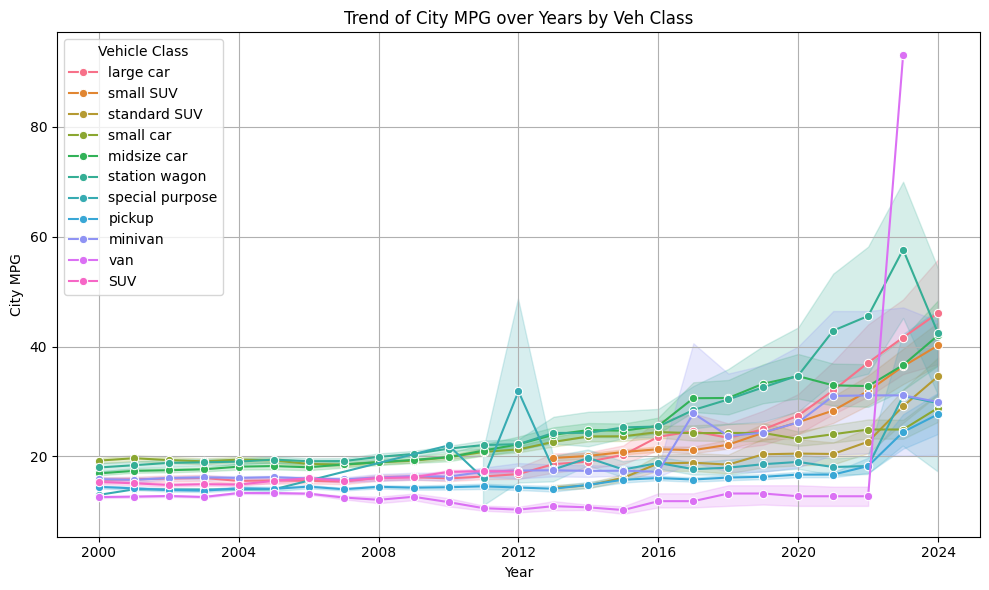

In [47]:
# Line plot comparing the City MPG by Vehicle Class over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Veh Class')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Class')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

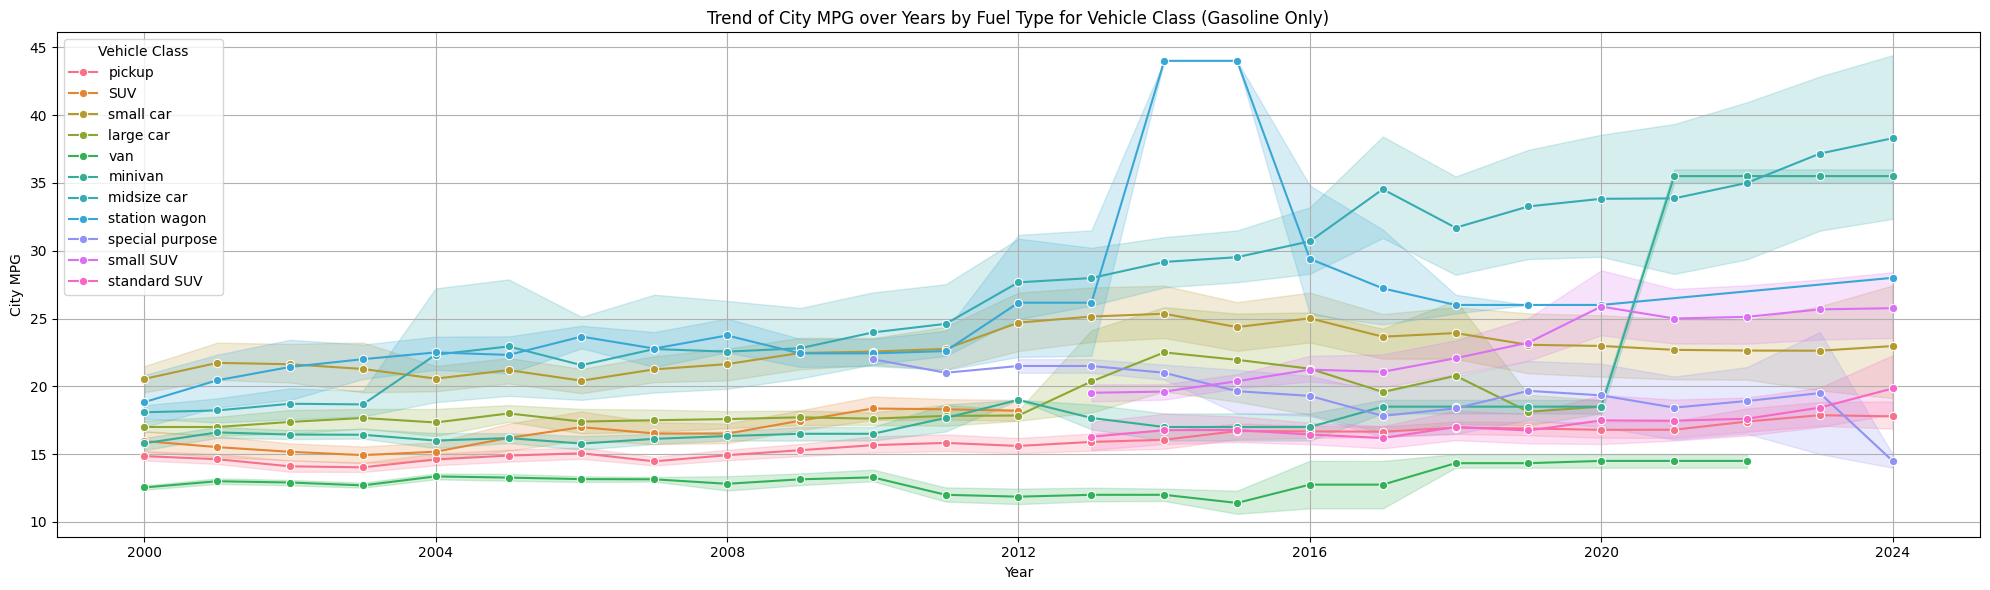

In [48]:
# sorted_gasoline_vehicles
plt.figure(figsize=(20, 6))
sns.lineplot(data=sorted_gasoline_vehicles, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Vehicle Class (Gasoline Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Class')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

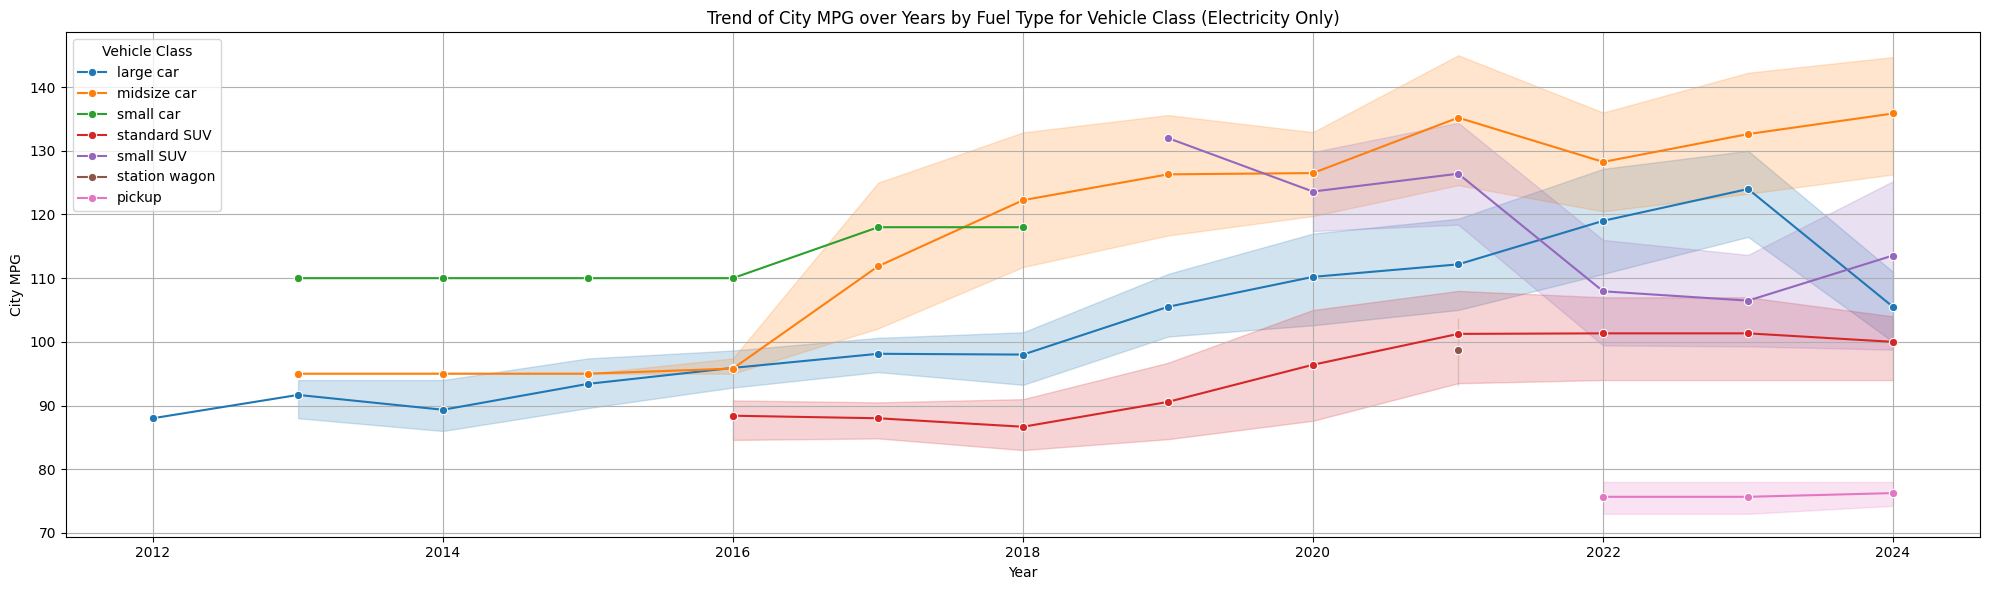

In [49]:
# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=sorted_electric_vehicles, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Vehicle Class (Electricity Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Class')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

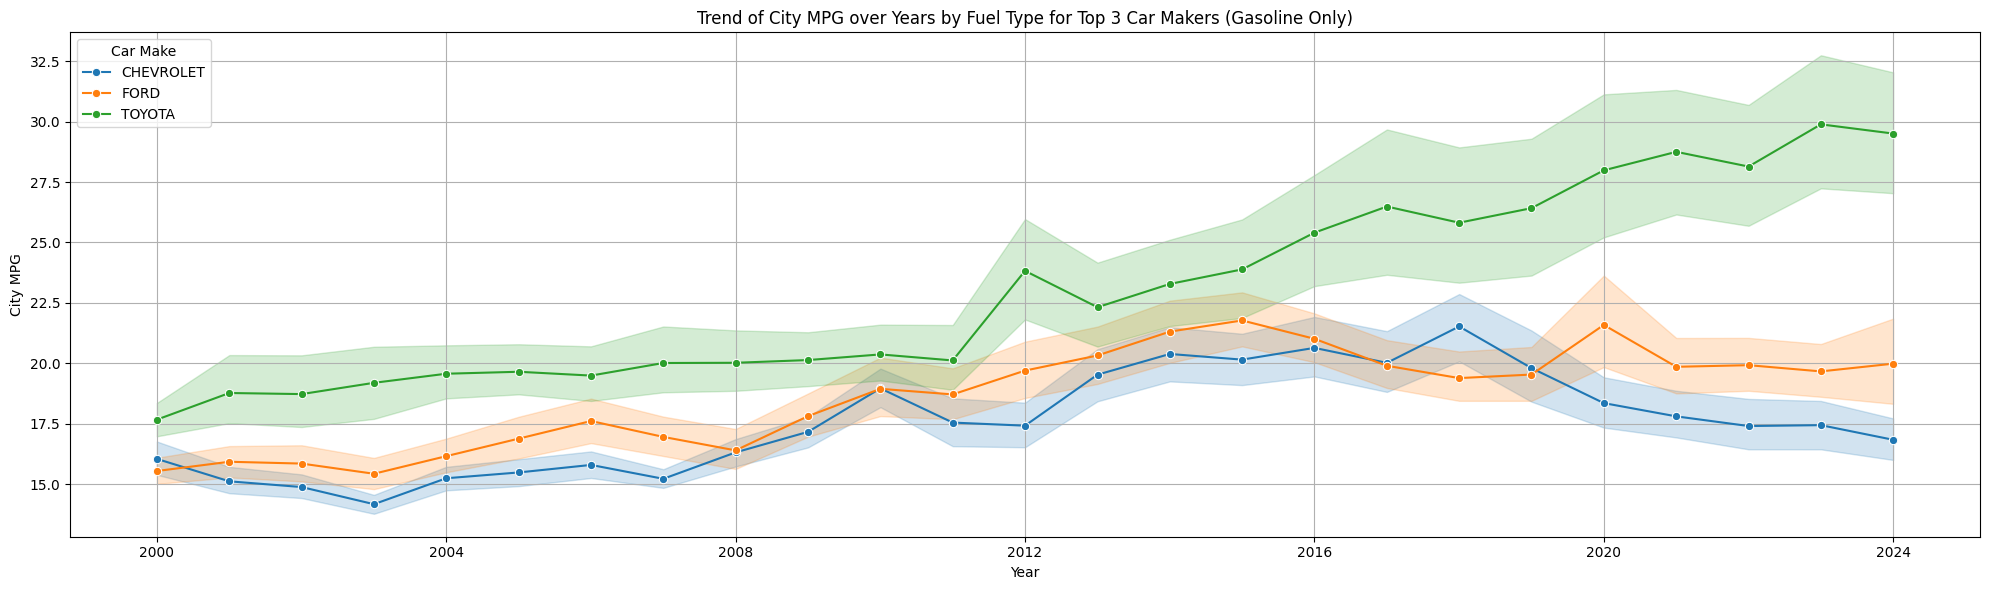

In [50]:
# Filter data for top 3 car makers and fuel type Gasoline
top_3_makers = ['FORD', 'TOYOTA', 'CHEVROLET']
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & (merged_data['Fuel'] == 'Gasoline')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Car_Make', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Top 3 Car Makers (Gasoline Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Car Make', loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

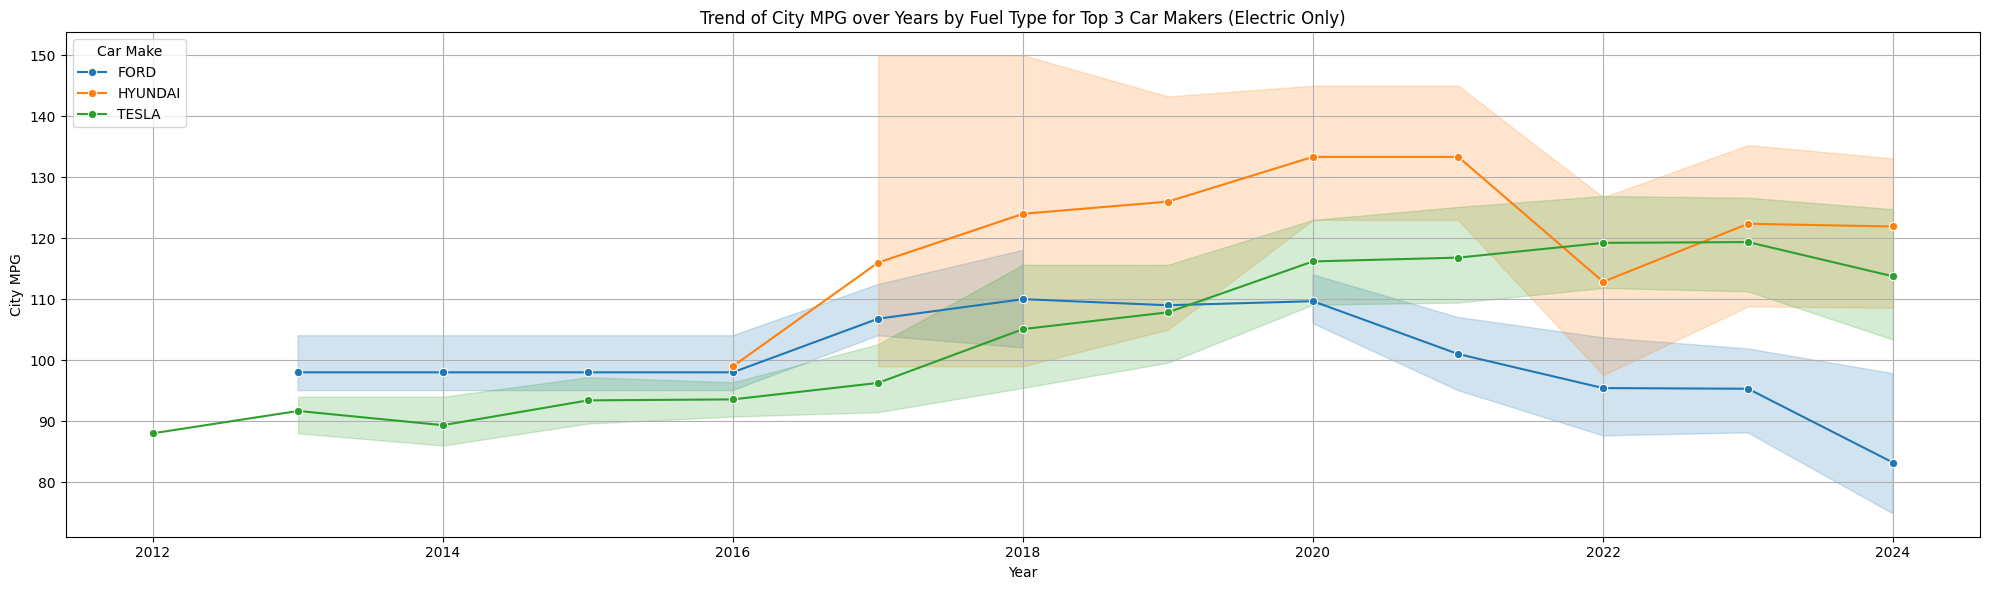

In [51]:
# Filter data for top 3 EV car makers and fuel type electricity
top_3_makers = ['TESLA', 'FORD', 'HYUNDAI'] #HYUNDAI NEED TO INCLUDE KIA AND GENESIS
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & (merged_data['Fuel'] == 'Electricity')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Car_Make', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Top 3 Car Makers (Electric Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Car Make', loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

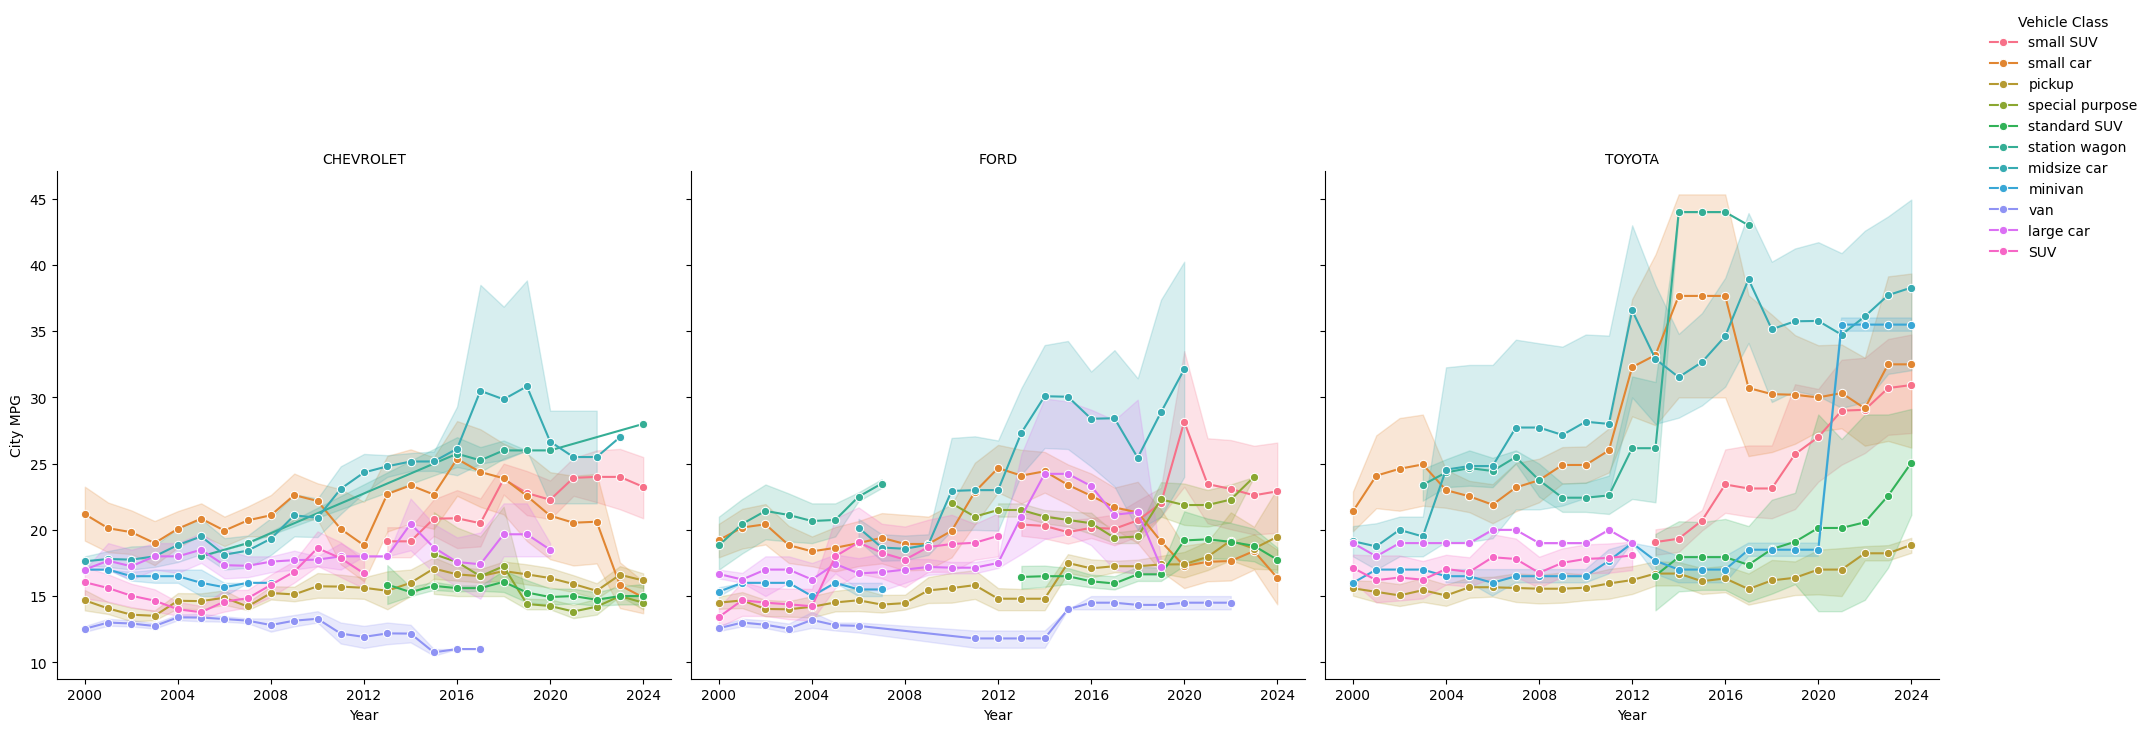

In [52]:
# Filter data for top 3 car makers, fuel type Gasoline, and vehicle class
top_3_makers = ['FORD', 'TOYOTA', 'CHEVROLET']
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & 
                            (merged_data['Fuel'] == 'Gasoline')]

# Check if there's data for each car make
available_makes = filtered_data['Car_Make'].unique()

# Create a FacetGrid only if there's data for at least one car make
if len(available_makes) > 0:
    # Create a FacetGrid
    g = sns.FacetGrid(filtered_data, col='Car_Make', hue='Veh Class', col_wrap=3, height=6, aspect=1)

    # Map a line plot onto the grid
    g.map(sns.lineplot, 'Year', 'City MPG', marker='o')

    # Set titles, labels, and legend
    g.set_titles('{col_name}')
    g.set_xlabels('Year')
    g.set_ylabels('City MPG')

    # Move legend outside the plot
    g.add_legend(title='Vehicle Class', bbox_to_anchor=(1.1, 1))

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No data available for the selected car makes.")

In [53]:
#6 filtered data sets

# GASOLINE
#FORD
sorted_gasoline_ford = sorted_gasoline_vehicles[sorted_gasoline_vehicles['Car_Make'] == 'FORD']
sorted_gasoline_ford = sorted_gasoline_ford.drop(columns=['Fuel', 'Car_Make'])
sorted_gasoline_ford = sorted_gasoline_ford.set_index('Year')

#TOYOTA
sorted_gasoline_toyota = sorted_gasoline_vehicles[sorted_gasoline_vehicles['Car_Make'] == 'TOYOTA']
sorted_gasoline_toyota = sorted_gasoline_toyota.drop(columns=['Fuel', 'Car_Make'])
sorted_gasoline_toyota = sorted_gasoline_toyota.set_index('Year')

#CHEVROLET
sorted_gasoline_chevrolet = sorted_gasoline_vehicles[sorted_gasoline_vehicles['Car_Make'] == 'CHEVROLET']
sorted_gasoline_chevrolet = sorted_gasoline_chevrolet.drop(columns=['Fuel', 'Car_Make'])
sorted_gasoline_chevrolet = sorted_gasoline_chevrolet.set_index('Year')

#ELECTRIC
#TELSA
sorted_electric_tesla = sorted_electric_vehicles[sorted_electric_vehicles['Car_Make'] == 'TESLA']
sorted_electric_tesla = sorted_electric_tesla.drop(columns=['Fuel', 'Car_Make'])
sorted_electric_tesla = sorted_electric_tesla.set_index('Year')

#HYUNDAI
sorted_electric_hyundai = sorted_electric_vehicles[sorted_electric_vehicles['Car_Make'] == 'HYUNDAI']
sorted_electric_hyundai = sorted_electric_hyundai.drop(columns=['Fuel', 'Car_Make'])
sorted_electric_hyundai = sorted_electric_hyundai.set_index('Year')

#FORD
sorted_electric_ford = sorted_electric_vehicles[sorted_electric_vehicles['Car_Make'] == 'FORD']
sorted_electric_ford = sorted_electric_ford.drop(columns=['Fuel', 'Car_Make'])
sorted_electric_ford = sorted_electric_ford.set_index('Year')

In [54]:
sorted_electric_ford

Displ  Cyl Drive      Veh Class Air Pollution Score  City MPG  \
Year                                                                        
2013-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2013-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2013-01-01    NaN  NaN   2WD      small car                 nan     110.0   
2013-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2013-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2014-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2014-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2014-01-01    NaN  NaN   2WD      small car                 nan     110.0   
2014-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2014-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2015-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2015-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2015-01-01    NaN  NaN   2WD      small car                 nan     110.0   
2015-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2015-01-01    2.0  4.0   2WD    midsize car                 nan      95.0   
2016-01-01    2.0  4.0   2WD    midsize car                 7.0      95.0   
2016-01-01    2.0  4.0   2WD    midsize car                 9.0      95.0   
2016-01-01    NaN  NaN   2WD      small car                10.0     110.0   
2016-01-01    2.0  4.0   2WD    midsize car                 7.0      95.0   
2016-01-01    2.0  4.0   2WD    midsize car                 9.0      95.0   
2017-01-01    2.0  4.0   2WD    midsize car                 9.0     104.0   
2017-01-01    NaN  NaN   2WD      small car                10.0     118.0   
2017-01-01    2.0  4.0   2WD    midsize car                 8.0     104.0   
2017-01-01    2.0  4.0   2WD    midsize car                 9.0     104.0   
2017-01-01    2.0  4.0   2WD    midsize car                 8.0     104.0   
2018-01-01    NaN  NaN   2WD      small car                10.0     118.0   
2018-01-01    2.0  4.0   2WD    midsize car                 7.0     102.0   
2019-01-01    2.0  4.0   2WD    midsize car                 7.0     109.0   
2020-01-01    2.0  4.0   2WD    midsize car                 7.0     106.0   
2020-01-01    2.0  4.0   2WD    midsize car                 7.0     109.0   
2020-01-01    2.5  4.0   2WD      small SUV                 7.0     114.0   
2021-01-01    NaN  NaN   4WD  station wagon                10.0      88.0   
2021-01-01    NaN  NaN   4WD  station wagon                10.0      90.0   
2021-01-01    NaN  NaN   4WD  station wagon                10.0      96.0   
2021-01-01    NaN  NaN   2WD  station wagon                10.0     105.0   
2021-01-01    NaN  NaN   2WD  station wagon                10.0     108.0   
2021-01-01    NaN  NaN   4WD  station wagon                10.0     100.0   
2021-01-01    2.5  4.0   2WD      small SUV                 7.0     117.0   
2021-01-01    NaN  NaN   2WD  station wagon                10.0     104.0   
2022-01-01    NaN  NaN   4WD      small SUV                10.0      97.0   
2022-01-01    NaN  NaN   4WD      small SUV                10.0      88.0   
2022-01-01    NaN  NaN   4WD      small SUV                10.0      90.0   
2022-01-01    NaN  NaN   2WD      small SUV                10.0     104.0   
2022-01-01    NaN  NaN   4WD         pickup                10.0      76.0   
2022-01-01    NaN  NaN   2WD      small SUV                10.0     108.0   
2022-01-01    NaN  NaN   4WD      small SUV                10.0      99.0   
2022-01-01    NaN  NaN   2WD      small SUV                10.0     110.0   
2022-01-01    NaN  NaN   4WD         pickup                10.0      78.0   
2022-01-01    2.5  4.0   2WD      small SUV                 7.0     117.0   
2022-01-01    NaN  NaN   4WD      small SUV                10.0     105.0   
2022-01-

In [55]:
# Split data into 80/20 train/test
train_size = int(len(average_city_mpg_by_year_fuel_and_make) * 0.8)
train, test = average_city_mpg_by_year_fuel_and_make[:train_size], average_city_mpg_by_year_fuel_and_make[train_size:]

In [56]:
# Check for stationarity
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# Check for stationarity in the train set
test_stationarity(train)

Dickey-Fuller test results:


ValueError: could not convert string to float: 'Gasoline'

In [ ]:
# Function to apply auto ARIMA model to each car make
def apply_auto_arima(data, car_make):
    # Selecting the data for the specific car make
    make_data = data[data['Car_Make'] == car_make]

    # Ensure the 'Year' column is in datetime format
    make_data['Year'] = pd.to_datetime(make_data['Year'], format='%Y')

    # Set the 'Year' column as the index and resample annually
    make_data = make_data.set_index('Year')['City MPG'].resample('A').mean().dropna()

    # Check if there is enough data to model
    if len(make_data) > 2:
        # Fit the auto ARIMA model
        model = auto_arima(make_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        
        # Print the summary of the model
        print(f"Auto ARIMA Model for {car_make}:")
        print(model.summary())

        # Forecasting next 3 years as an example
        forecast = model.predict(n_periods=3)
        forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')
        forecast_series = pd.Series(forecast, index=forecast_index)
        
        # Plot the historical data and forecast
        plt.figure(figsize=(10, 6))
        plt.plot(make_data, label='Historical')
        plt.plot(forecast_series, label='Forecast', color='red')
        plt.title(f'City MPG Forecast for {car_make}')
        plt.xlabel('Year')
        plt.ylabel('City MPG')
        plt.legend()
        plt.show()

# Apply auto ARIMA model to each car make
car_makes = ['FORD', 'CHEVROLET', 'TOYOTA']
for make in car_makes:
    apply_auto_arima(average_city_mpg_by_year_fuel_and_make, make)


KeyError: 'Car_Make'

In [ ]:
# Function to apply auto ARIMA model to each car make
def apply_auto_arima(data, car_make):
    # Selecting the data for the specific car make
    make_data = data[data['Car_Make'] == car_make]
    make_data = make_data.set_index('Year')['City MPG'].resample('A').mean().dropna()

    # Check if there is enough data to model
    if len(make_data) > 2:
        # Fit the auto ARIMA model
        model = auto_arima(make_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        
        # Print the summary of the model
        print(f"Auto ARIMA Model for {car_make}:")
        print(model.summary())

        # Forecasting next 3 years as an example
        forecast = model.predict(n_periods=3)
        forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')
        forecast_series = pd.Series(forecast, index=forecast_index)
        
        # Plot the historical data and forecast
        plt.figure(figsize=(10, 6))
        plt.plot(make_data, label='Historical')
        plt.plot(forecast_series, label='Forecast', color='red')
        plt.title(f'City MPG Forecast for {car_make}')
        plt.xlabel('Year')
        plt.ylabel('City MPG')
        plt.legend()
        plt.show()

# Apply auto ARIMA model to each car make
car_makes = ['FORD', 'CHEVY', 'TOYOTA']
for make in car_makes:
    apply_auto_arima(sorted_electric_vehicles, make)

/tmp/ipykernel_80643/1046389687.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  make_data = make_data.set_index('Year')['City MPG'].resample('A').mean().dropna()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
# Preparing the data

# Filter and sort data as previously described
car_makes = ['FORD', 'TESLA', 'HYUNDAI']
filtered_data = merged_data[(merged_data['Car_Make'].isin(car_makes)) & (merged_data['Fuel'] == 'Electricity')]
sorted_electric_vehicles = filtered_data.sort_values(by='Year')

# Convert 'Year' to datetime and set as index
sorted_electric_vehicles['Year'] = pd.to_datetime(sorted_electric_vehicles['Year'], format='%Y')
sorted_electric_vehicles.set_index('Year', inplace=True)

/tmp/ipykernel_80643/2973037741.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  make_data = data[data['Car_Make'] == car_make]['City MPG'].resample('A').mean().dropna()
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_80643/2973037741.py:19: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')


ARIMA Model for FORD:
                               SARIMAX Results                                
Dep. Variable:               City MPG   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -34.007
Date:                Fri, 17 May 2024   AIC                             74.013
Time:                        22:38:24   BIC                             75.207
Sample:                    12-31-2013   HQIC                            73.261
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6802      0.834      0.816      0.415      -0.954       2.315
ma.L1         -0.3945      1.140     -0.346      0.729      -2.630       1.841
sigma2        27.9418     13.5

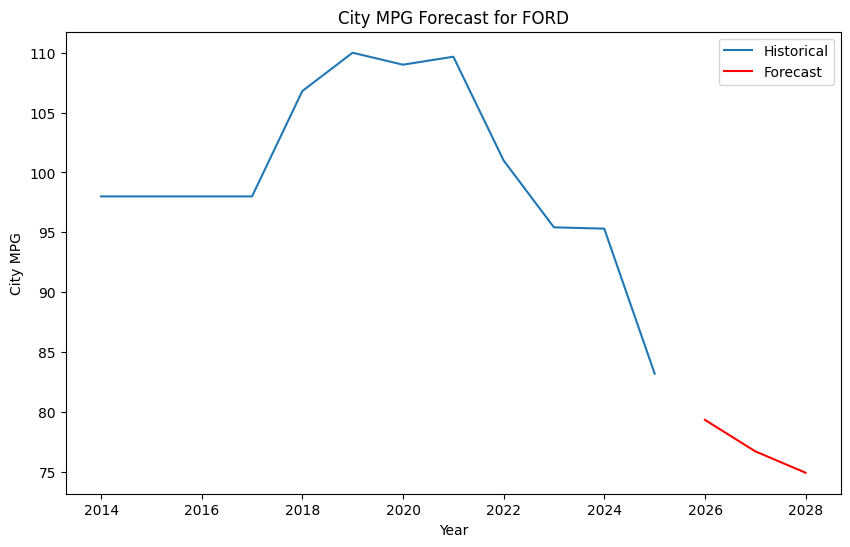

/tmp/ipykernel_80643/2973037741.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  make_data = data[data['Car_Make'] == car_make]['City MPG'].resample('A').mean().dropna()
/tmp/ipykernel_80643/2973037741.py:19: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')


ARIMA Model for TESLA:
                               SARIMAX Results                                
Dep. Variable:               City MPG   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -33.895
Date:                Fri, 17 May 2024   AIC                             73.791
Time:                        22:38:24   BIC                             75.246
Sample:                    12-31-2012   HQIC                            73.252
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7457      0.611      1.221      0.222      -0.451       1.942
ma.L1         -0.4739      1.153     -0.411      0.681      -2.733       1.785
sigma2        16.3654     11.

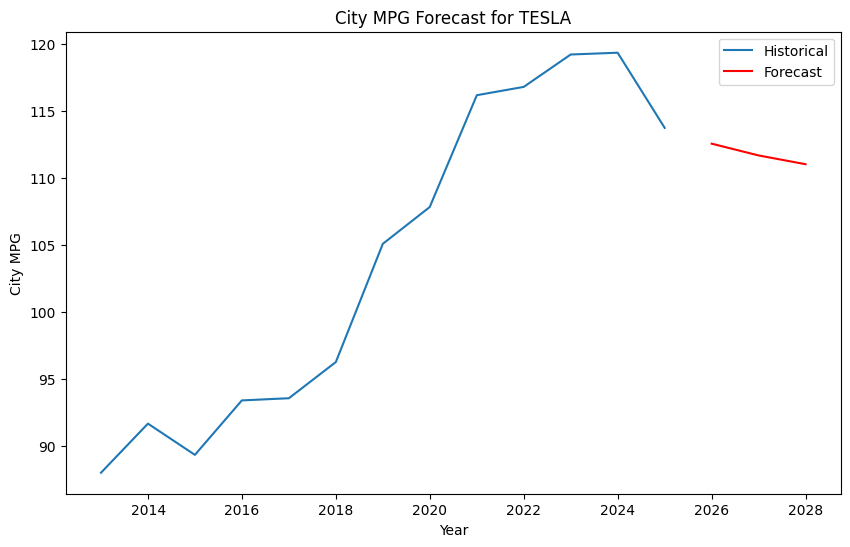

/tmp/ipykernel_80643/2973037741.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  make_data = data[data['Car_Make'] == car_make]['City MPG'].resample('A').mean().dropna()
/tmp/ipykernel_80643/2973037741.py:19: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')


ARIMA Model for HYUNDAI:
                               SARIMAX Results                                
Dep. Variable:               City MPG   No. Observations:                    9
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -30.257
Date:                Fri, 17 May 2024   AIC                             66.513
Time:                        22:38:25   BIC                             66.751
Sample:                    12-31-2016   HQIC                            64.906
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8023      1.353      0.593      0.553      -1.849       3.454
ma.L1         -0.9984     60.414     -0.017      0.987    -119.408     117.411
sigma2       104.4959   623

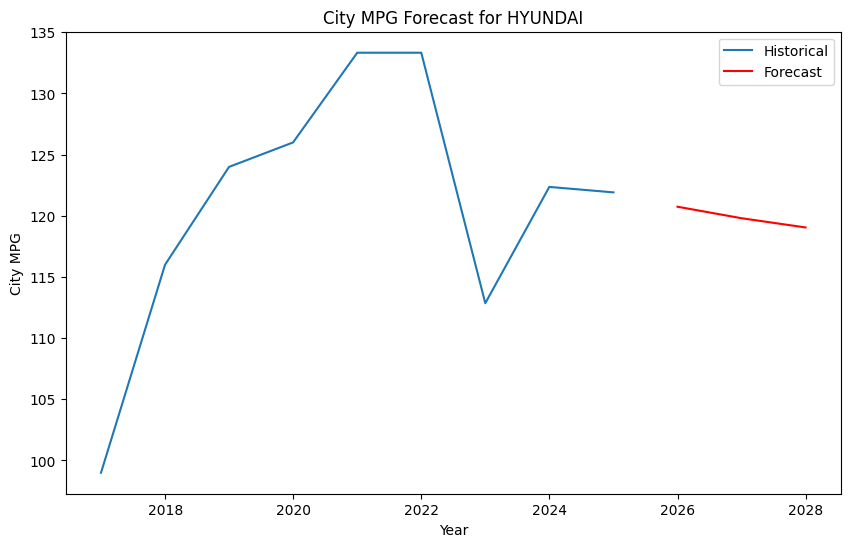

In [ ]:
# Function to apply ARIMA model to each car make

def apply_arima(data, car_make):
    # Selecting the data for the specific car make
    make_data = data[data['Car_Make'] == car_make]['City MPG'].resample('A').mean().dropna()

    # Check if there is enough data to model
    if len(make_data) > 2:
        # Fit the ARIMA model
        model = ARIMA(make_data, order=(1,1,1))  # Placeholder order, should be optimized
        fitted_model = model.fit()
        
        # Print the summary of the model
        print(f"ARIMA Model for {car_make}:")
        print(fitted_model.summary())

        # Forecasting next 3 years as an example
        forecast = fitted_model.get_forecast(steps=3)
        forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')
        forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
        
        # Plot the historical data and forecast
        plt.figure(figsize=(10, 6))
        plt.plot(make_data, label='Historical')
        plt.plot(forecast_series, label='Forecast', color='red')
        plt.title(f'City MPG Forecast for {car_make}')
        plt.xlabel('Year')
        plt.ylabel('City MPG')
        plt.legend()
        plt.show()

# Apply ARIMA model to each car make
for make in car_makes:
    apply_arima(sorted_electric_vehicles, make)


In [ ]:
# Same ARIMA but for gasoline

# Filter and sort data as previously described
car_makes = ['FORD', 'CHEVROLET', 'TOYOTA']
filtered_data = merged_data[(merged_data['Car_Make'].isin(car_makes)) & (merged_data['Fuel'] == 'Gasoline')]
sorted_gasoline_vehicles = filtered_data.sort_values(by='Year')

# Convert 'Year' to datetime and set as index
sorted_gasoline_vehicles['Year'] = pd.to_datetime(sorted_electric_vehicles['Year'], format='%Y')
sorted_gasoline_vehicles.set_index('Year', inplace=True)

In [ ]:


# Function to apply auto ARIMA model to each car make
def apply_auto_arima(data, car_make):
    # Selecting the data for the specific car make
    make_data = data[data['Car_Make'] == car_make]

    # Ensure the 'Year' column is in datetime format
    make_data['Year'] = pd.to_datetime(make_data['Year'], format='%Y', errors='coerce')  # Coerce errors to NaT
    print('Year')
    # Drop rows with NaT values in 'Year'
    make_data = make_data.dropna(subset=['Year'])

    # Set the 'Year' column as the index and resample annually
    make_data = make_data.set_index('Year')['City MPG'].resample('A').mean().dropna()

    # Check if there is enough data to model
    if len(make_data) > 2:
        # Fit the auto ARIMA model
        model = auto_arima(make_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        
        # Print the summary of the model
        print(f"Auto ARIMA Model for {car_make}:")
        print(model.summary())

        # Forecasting next 3 years as an example
        forecast = model.predict(n_periods=3)
        forecast_index = pd.date_range(start=make_data.index[-1] + pd.DateOffset(years=1), periods=3, freq='A')
        forecast_series = pd.Series(forecast, index=forecast_index)
        
        # Plot the historical data and forecast
        plt.figure(figsize=(10, 6))
        plt.plot(make_data, label='Historical')
        plt.plot(forecast_series, label='Forecast', color='red')
        plt.title(f'City MPG Forecast for {car_make}')
        plt.xlabel('Year')
        plt.ylabel('City MPG')
        plt.legend()
        plt.show()

# Apply auto ARIMA model to each car make
car_makes = ['FORD', 'CHEVY', 'TOYOTA']
for make in car_makes:
    apply_auto_arima(sorted_electric_vehicles, make)


KeyError: 'Year'

In [ ]:
categorical_features = ["Cyl", 
                        "Drive", 
                        "Fuel",
                        "Veh Class",
                        "Car_Make", 
                        "Car_Model"]

In [ ]:
numerical_features = ["Displ",                       
                      "Air Pollution Score",
                      "City MPG"
                      "Hwy MPG"
                      "Cmb MPG"
                      "Greenhouse Gas Score", 
                      "Year"]

In [ ]:
# Define features and target

X = merged_data.drop(columns=['Car_Make', 'Year', 'Veh Class'])
y = merged_data['City MPG']

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Pipeline creation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit the pipeline

# pipeline.fit(X_train, y_train)